عدد العقد: 34
عدد الحواف: 78
متوسط درجة العقدة: 4.59


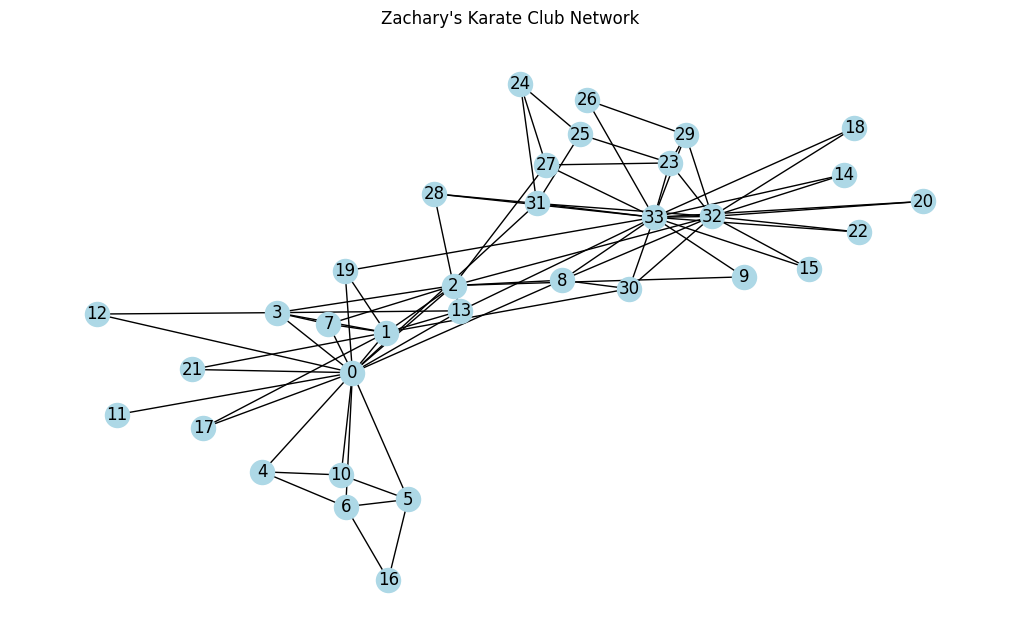

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from itertools import chain, combinations
import numpy as np

# تحميل مجموعة البيانات
G = nx.karate_club_graph()

# معلومات الشبكة
print(f"عدد العقد: {G.number_of_nodes()}")
print(f"عدد الحواف: {G.number_of_edges()}")
print(f"متوسط درجة العقدة: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

# رسم الشبكة الأساسية
plt.figure(figsize=(10, 6))
nx.draw_spring(G, with_labels=True, node_color='lightblue')
plt.title("Zachary's Karate Club Network")
plt.show()

خوارزمية Girvan-Newman تُستخدم لتقسيم شبكة Zachary's Karate Club إلى مجتمعات


تكتشف المجتمعات الاجتماعية في الشبكة (مثل مجموعة الأعضاء الموالين للمدرب ومجموعة الأعضاء الموالين للمدير).

تُظهر كيف تنقسم الشبكة بناءً على قوة العلاقات بين الأعضاء.


Girvan-Newman

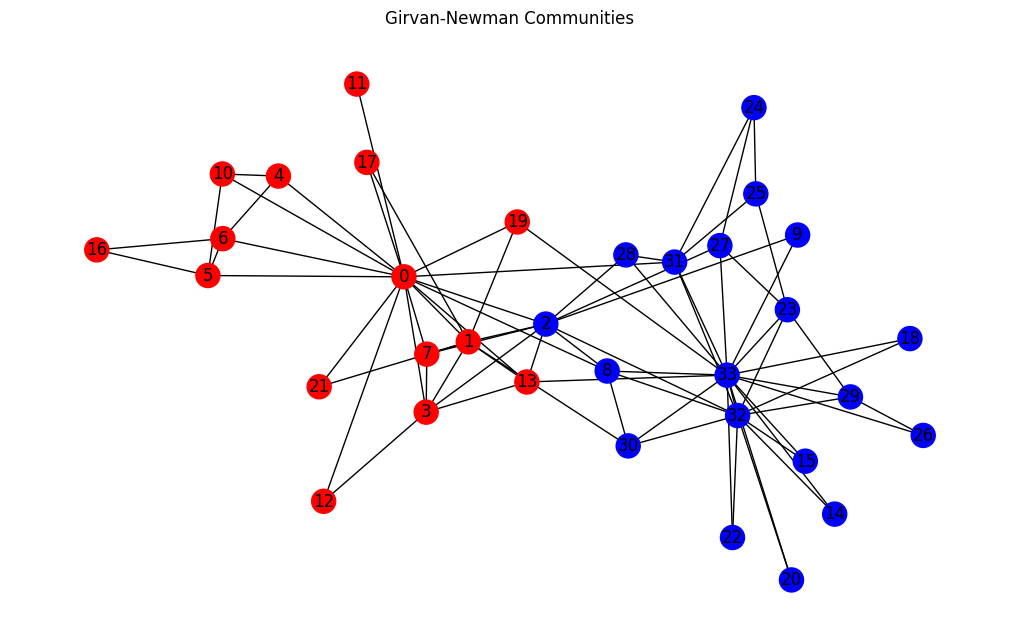

In [ ]:
# تطبيق خوارزمية Girvan-Newman
def apply_girvan_newman(graph, k=2):
    comp = girvan_newman(graph)
    communities = []
    for c in next(comp):
        communities.append(list(c))
    return communities

gn_communities = apply_girvan_newman(G)

# رسم النتائج
def draw_communities(graph, communities, title):
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    node_colors = []
    for node in graph.nodes():
        for i, community in enumerate(communities):
            if node in community:
                node_colors.append(colors[i % len(colors)])
                break
    plt.figure(figsize=(10, 6))
    nx.draw_spring(graph, node_color=node_colors, with_labels=True)
    plt.title(title)
    plt.show()
draw_communities(G, gn_communities, "Girvan-Newman Communities")

خوارزمية Ravasz الهرمية تُستخدم لتقسيم الشبكة (مثل Zachary's Karate Club) إلى مجتمعات باستخدام التجميع الهرمي (Hierarchical Clustering) بناءً على المسافات بين العقد

تُقسم الشبكة (مثل Karate Club) إلى مجتمعات بناءً على قرب العقد (المسافات القصيرة بين الأشخاص في النادي).

تُحدد مجموعات مترابطة (مثل مجموعة الأعضاء الموالين للمدرب أو المدير) بناءً على كثافة الاتصالات.

Ravasz Hierarchical 

C:\Users\original\AppData\Local\Temp\ipykernel_6848\3388928527.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distances, method='average')


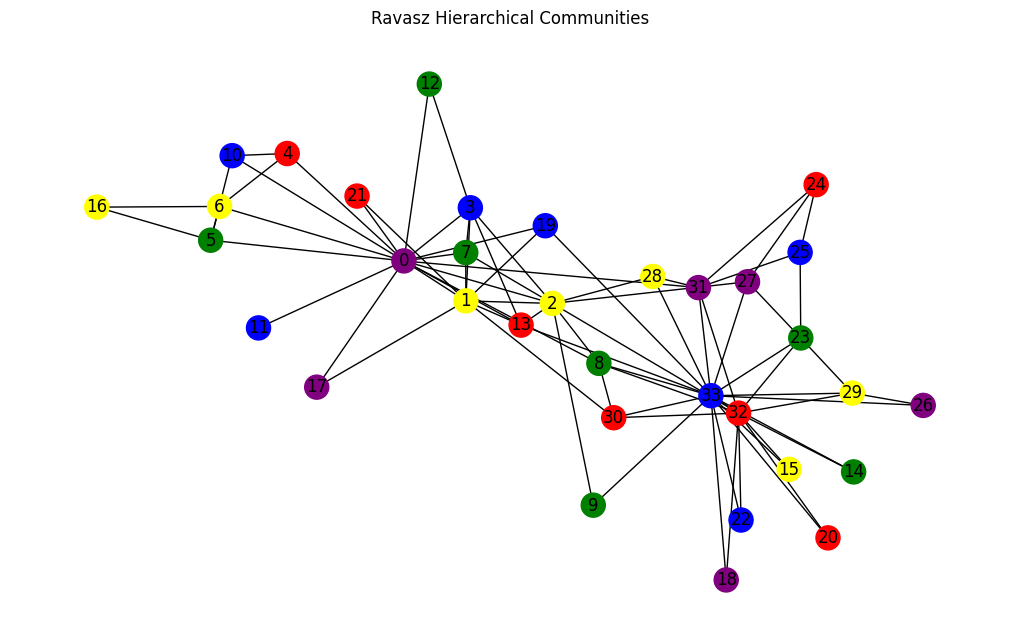

In [3]:
# تطبيق خوارزمية Ravasz الهرمية
def apply_ravasz(graph, threshold=0.7):
    # حساب مصفوفة المسافات
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    distances = np.zeros((G.number_of_nodes(), G.number_of_nodes()))
    
    for i, node1 in enumerate(G.nodes()):
        for j, node2 in enumerate(G.nodes()):
            distances[i,j] = path_length[node1][node2]
    
    # تطبيق clustering هرمي
    from scipy.cluster.hierarchy import linkage, fcluster
    Z = linkage(distances, method='average')
    communities = fcluster(Z, t=threshold, criterion='distance')
    
    # تحويل إلى تنسيق communities
    unique_clusters = set(communities)
    ravasz_communities = []
    for cluster in unique_clusters:
        community = [i for i, x in enumerate(communities) if x == cluster]
        ravasz_communities.append(community)
    
    return ravasz_communities

ravasz_communities = apply_ravasz(G)

draw_communities(G, ravasz_communities, "Ravasz Hierarchical Communities")

خوارزمية Clique Percolation Method (CPM) تُستخدم للكشف عن المجتمعات في الشبكة (مثل Zachary's Karate Club) بناءً على مفهوم k-cliques (مجموعات من العقد مترابطة بالكامل بحجم 
𝑘
k أو أكثر).

  Clique Percolation

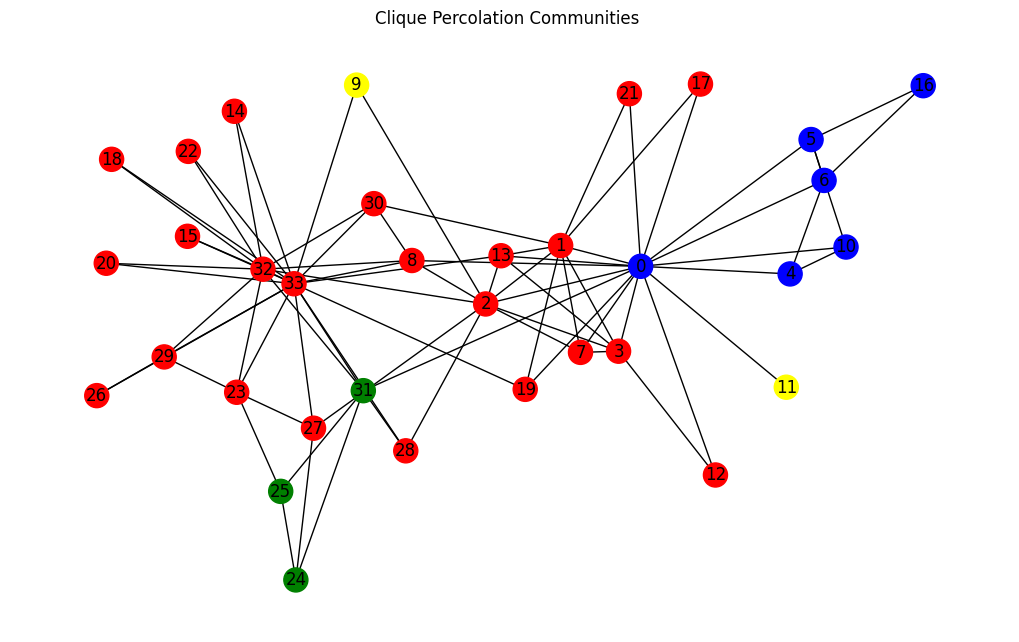

In [4]:
def apply_clique_percolation(graph, k=3):
    # إيجاد جميع cliques بحجم k
    cliques = list(nx.find_cliques(graph))
    k_cliques = [clique for clique in cliques if len(clique) >= k]
    
    if not k_cliques:
        return [list(graph.nodes())]  # إذا لم نجد أي cliques، نعتبر كل العقد مجتمع واحد
    
    # بناء clique graph
    clique_graph = nx.Graph()
    for i, clique in enumerate(k_cliques):
        clique_graph.add_node(i)
    
    for i in range(len(k_cliques)):
        for j in range(i+1, len(k_cliques)):
            if len(set(k_cliques[i]) & set(k_cliques[j])) >= k-1:
                clique_graph.add_edge(i, j)
    
    # إيجاد المكونات المتصلة
    communities = list(nx.connected_components(clique_graph))
    
    # تحويل إلى تنسيق العقد
    node_communities = []
    for com in communities:
        community = set()
        for clique_idx in com:
            community.update(k_cliques[clique_idx])
        node_communities.append(list(community))
    
    # إضافة العقد غير المضمنة في أي مجتمع كمجتمع منفصل
    all_covered_nodes = set().union(*[set(c) for c in node_communities])
    uncovered_nodes = set(graph.nodes()) - all_covered_nodes
    if uncovered_nodes:
        node_communities.append(list(uncovered_nodes))
    
    return node_communities

def draw_communities(graph, communities, title):
    # إنشاء قاموس لتعيين العقدة إلى لونها
    node_to_color = {}
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown']
    
    for i, community in enumerate(communities):
        for node in community:
            node_to_color[node] = colors[i % len(colors)]
    
    # إنشاء قائمة الألوان مرتبة حسب العقد في الرسم البياني
    node_colors = [node_to_color.get(node, 'gray') for node in graph.nodes()]
    
    plt.figure(figsize=(10, 6))
    nx.draw_spring(graph, node_color=node_colors, with_labels=True)
    plt.title(title)
    plt.show()

# تطبيق الخوارزمية المعدلة
clique_communities = apply_clique_percolation(G, k=3)
draw_communities(G, clique_communities, "Clique Percolation Communities ")

Comparsion between Girvan-Newman, Ravasz Hierarchical and Clique Percolation

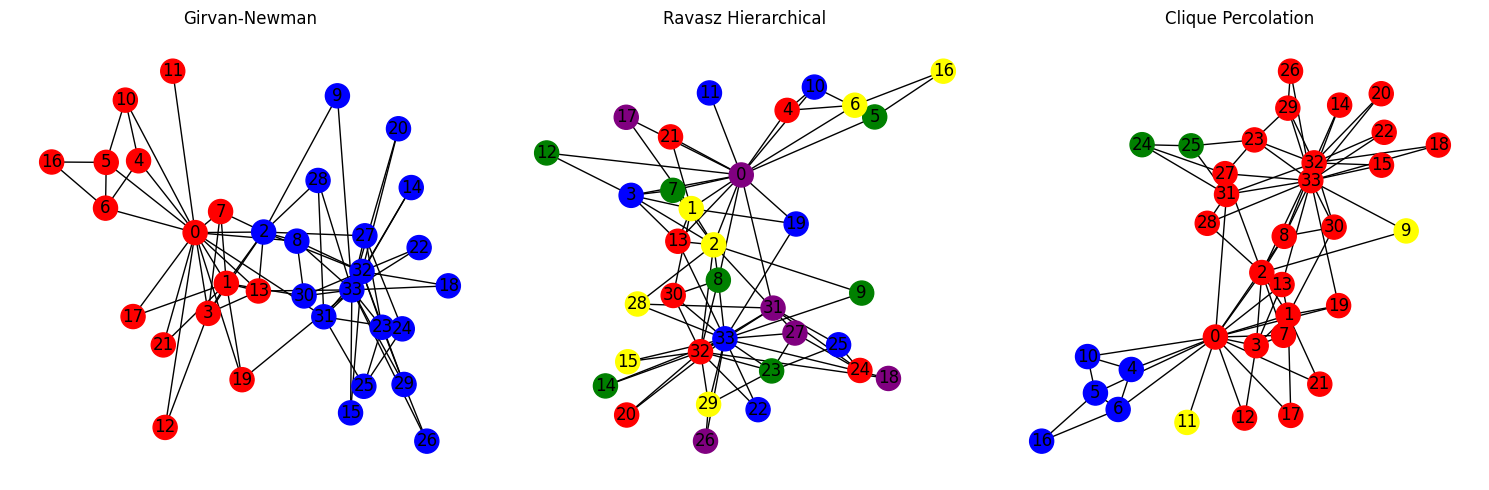

In [7]:
# مقارنة نتائج الخوارزميات
def compare_communities(communities_list, names):
    plt.figure(figsize=(15, 5))
    for i, (communities, name) in enumerate(zip(communities_list, names)):
        plt.subplot(1, 3, i+1)
        colors = ['red', 'blue', 'green', 'yellow', 'purple']
        node_colors = []
        for node in G.nodes():
            for j, community in enumerate(communities):
                if node in community:
                    node_colors.append(colors[j % len(colors)])
                    break
        nx.draw_spring(G, node_color=node_colors, with_labels=True)
        plt.title(name)
    plt.tight_layout()
    plt.show()

# تنفيذ المقارنة
algorithms = [gn_communities, ravasz_communities, clique_communities]
names = ["Girvan-Newman", "Ravasz Hierarchical", "Clique Percolation"]
compare_communities(algorithms, names)

Analytic between Girvan-Newman, Ravasz Hierarchical and Clique Percolation

In [ ]:
!pip install sklearn

^C


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [8]:
# حساب مقاييس الجودة للتجميع
from sklearn import metrics

# إنشاء تسميات حقيقية (المجموعات الأصلية في البيانات)
true_labels = [0 if G.nodes[n]['club'] == 'Mr. Hi' else 1 for n in G.nodes()]

def evaluate_communities(communities, true_labels, name):
    # تحويل التجميع إلى تسميات
    pred_labels = np.zeros(len(true_labels))
    for i, com in enumerate(communities):
        for node in com:
            pred_labels[node] = i
    
    # حساب المقاييس
    ari = metrics.adjusted_rand_score(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    
    print(f"{name} Algorithm Evaluation:")
    print(f"Adjusted Rand Index: {ari:.3f}")
    print(f"Normalized Mutual Info: {nmi:.3f}\n")

# تقييم كل خوارزمية
evaluate_communities(gn_communities, true_labels, "Girvan-Newman")
evaluate_communities(ravasz_communities, true_labels, "Ravasz")
evaluate_communities(clique_communities, true_labels, "Clique Percolation")

ModuleNotFoundError: No module named 'sklearn'

Girvan-Newman:

تعتمد على إزالة الحواف ذات أعلى betweenness

تميل إلى إنتاج مجتمعات متوازنة الحجم

حساسة لبنية الشبكة الهرمية

Ravasz:

خوارزمية تسلسل هرمي

تعمل جيداً مع البيانات التي لها بنية هرمية واضحة

تحتاج لضبط معامل العتبة (threshold)

Clique Percolation:

تعتمد على اكتشاف المجتمعات الكثيفة (cliques)

مناسبة للشبكات ذات الكثافة العالية

حساسة لاختيار حجم الـ clique (k)